In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Reshape, Conv2DTranspose, MaxPooling2D, UpSampling2D, LeakyReLU
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
print("Tensorflow", tf.__version__)


Tensorflow 2.2.0


## Load MNIST dataset

In [2]:
(ds_train, ds_test_), ds_info = tfds.load('mnist', 
                              split=['train', 'test'], 
                              shuffle_files=True,
                              as_supervised=True,
                              with_info=True)


batch_size = 256
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = image/255.
    return image, image


ds_train = ds_train.map(preprocess)
ds_train = ds_train.cache() # put dataset into memory
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size)

ds_test = ds_test_.map(preprocess).batch(batch_size).cache().prefetch(batch_size)



In [3]:
# return label for testing
def preprocess_with_label(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.math.round(image/255.)
    return image, label

ds_test_label = ds_test_.map(preprocess_with_label).batch(1000)

# Building Autoencoder

In [4]:
def Encoder(z_dim):
    inputs  = layers.Input(shape=[28,28,1])
    
    x = inputs    
    x = Conv2D(filters=8,  kernel_size=(3,3), strides=2, padding='same', activation='relu')(x)
    x = Conv2D(filters=8,  kernel_size=(3,3), strides=1, padding='same', activation='relu')(x)
    x = Conv2D(filters=8,  kernel_size=(3,3), strides=2, padding='same', activation='relu')(x)
    x = Conv2D(filters=8,  kernel_size=(3,3), strides=1, padding='same', activation='relu')(x)
    x = Flatten()(x)
    out = Dense(z_dim)(x)
    
    return Model(inputs=inputs, outputs=out, name='encoder')

def Decoder(z_dim):
    inputs  = layers.Input(shape=[z_dim])
    x = inputs    
    x = Dense(7*7*64, activation='relu')(x)
    x = Reshape((7,7,64))(x)

    x = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same', activation='relu')(x)
    x = UpSampling2D((2,2))(x)
    
    x = Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same', activation='relu')(x)
    x = UpSampling2D((2,2))(x)    

    out = Conv2D(filters=1, kernel_size=(3,3), strides=1, padding='same', activation='sigmoid')(x)
    
    #return out          
    return Model(inputs=inputs, outputs=out, name='decoder')

class Autoencoder:
    def __init__(self, z_dim):
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
        
        model_input = self.encoder.input
        model_output = self.decoder(self.encoder.output)
        self.model = Model(model_input, model_output)
        


In [5]:
autoencoder = Autoencoder(z_dim=10)


In [6]:
model_path = "./models/autoencoder.h5"
checkpoint = ModelCheckpoint(model_path, 
                             monitor= "val_loss", 
                             verbose=1, 
                             save_best_only=True, 
                             mode= "auto", 
                             save_weights_only = False)

early = EarlyStopping(monitor= "val_loss", 
                      mode= "auto", 
                      patience = 5)

callbacks_list = [checkpoint, early]

autoencoder.model.compile(
    loss = "mse",
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=3e-4))
    #metrics=[tf.keras.losses.BinaryCrossentropy()])
autoencoder.model.fit(ds_train, validation_data=ds_test,
                epochs = 100, callbacks = callbacks_list)

Epoch 1/100
235/235 [==============================] - ETA: 0s - loss: 0.0656
Epoch 00001: val_loss improved from inf to 0.04128, saving model to ./models/autoencoder.h5
235/235 [==============================] - 2s 7ms/step - loss: 0.0656 - val_loss: 0.0413
Epoch 2/100
232/235 [============================>.] - ETA: 0s - loss: 0.0349
Epoch 00002: val_loss improved from 0.04128 to 0.02908, saving model to ./models/autoencoder.h5
235/235 [==============================] - 1s 6ms/step - loss: 0.0349 - val_loss: 0.0291
Epoch 3/100
228/235 [============================>.] - ETA: 0s - loss: 0.0278
Epoch 00003: val_loss improved from 0.02908 to 0.02624, saving model to ./models/autoencoder.h5
235/235 [==============================] - 1s 6ms/step - loss: 0.0277 - val_loss: 0.0262
Epoch 4/100
228/235 [============================>.] - ETA: 0s - loss: 0.0246
Epoch 00004: val_loss improved from 0.02624 to 0.02269, saving model to ./models/autoencoder.h5
235/235 [==============================] 

Epoch 34/100
229/235 [============================>.] - ETA: 0s - loss: 0.0147
Epoch 00034: val_loss improved from 0.01508 to 0.01490, saving model to ./models/autoencoder.h5
235/235 [==============================] - 1s 6ms/step - loss: 0.0148 - val_loss: 0.0149
Epoch 35/100
231/235 [============================>.] - ETA: 0s - loss: 0.0147
Epoch 00035: val_loss did not improve from 0.01490
235/235 [==============================] - 1s 6ms/step - loss: 0.0147 - val_loss: 0.0150
Epoch 36/100
231/235 [============================>.] - ETA: 0s - loss: 0.0146
Epoch 00036: val_loss improved from 0.01490 to 0.01476, saving model to ./models/autoencoder.h5
235/235 [==============================] - 1s 6ms/step - loss: 0.0146 - val_loss: 0.0148
Epoch 37/100
228/235 [============================>.] - ETA: 0s - loss: 0.0145
Epoch 00037: val_loss did not improve from 0.01476
235/235 [==============================] - 1s 6ms/step - loss: 0.0145 - val_loss: 0.0149
Epoch 38/100
230/235 [============

# Sample and Display Images

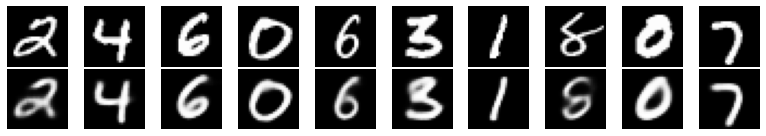

In [7]:
images, labels = next(iter(ds_test))
autoencoder.model = load_model(model_path)
outputs = autoencoder.model.predict(images)

# Display
grid_col = 10
grid_row = 2

f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*1.1, grid_row))

i = 0
for row in range(0, grid_row, 2):
    for col in range(grid_col):
        axarr[row,col].imshow(images[i,:,:,0], cmap='gray')
        axarr[row,col].axis('off')
        axarr[row+1,col].imshow(outputs[i,:,:,0], cmap='gray')
        axarr[row+1,col].axis('off')        
        i += 1
f.tight_layout(0.1, h_pad=0.2, w_pad=0.1)        
plt.show()

## Set z_dim = 2 and to look at the latent variables

In [8]:
autoencoder_2 = Autoencoder(z_dim=2)

early = EarlyStopping(monitor= "val_loss", 
                      mode= "auto", 
                      patience = 5)

callbacks_list = [early]

autoencoder_2.model.compile(
    loss = "mse",
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3))

autoencoder_2.model.fit(ds_train, validation_data=ds_test,
                epochs = 50, callbacks = callbacks_list)

Epoch 1/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0634 - val_loss: 0.0549
Epoch 2/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0519 - val_loss: 0.0498
Epoch 3/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0494 - val_loss: 0.0490
Epoch 4/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0478 - val_loss: 0.0476
Epoch 5/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0467 - val_loss: 0.0463
Epoch 6/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0459 - val_loss: 0.0458
Epoch 7/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0453 - val_loss: 0.0455
Epoch 8/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0447 - val_loss: 0.0451
Epoch 9/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0443 - val_loss: 0.0441
Epoch 10/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0439 - val_loss: 0.0436

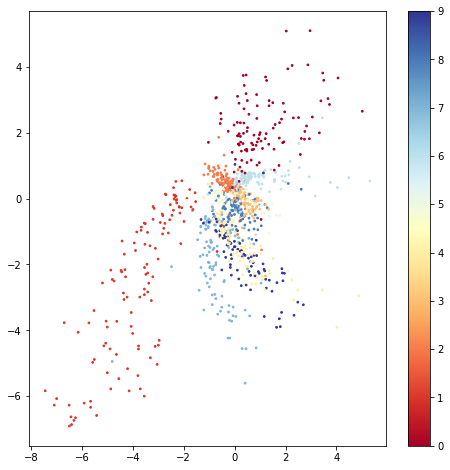

In [9]:
images, labels = next(iter(ds_test_label))
outputs = autoencoder_2.encoder.predict(images)
plt.figure(figsize=(8,8))
plt.scatter(outputs[:,0], outputs[:,1], c=labels, cmap='RdYlBu', s=3)
plt.colorbar()

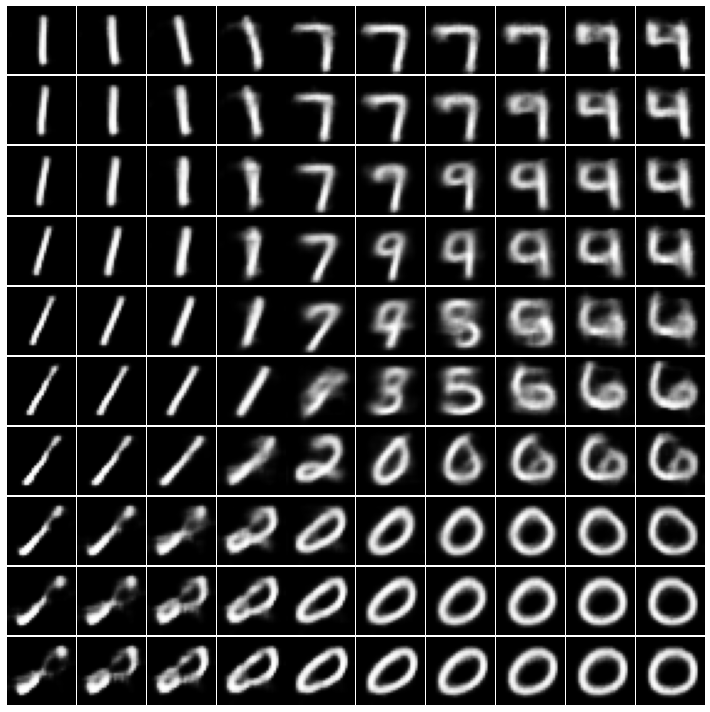

In [10]:
z_samples = np.array([[z1, z2] for z2 in np.arange(-5, 5, 1.) for z1 in np.arange(-5, 5, 1.)])
images = autoencoder_2.decoder.predict(z_samples)
grid_col = 10
grid_row = 10

f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col, grid_row))

i = 0
for row in range(grid_row):
    for col in range(grid_col):
        axarr[row,col].imshow(images[i,:,:,0], cmap='gray')
        axarr[row,col].axis('off')   
        i += 1
f.tight_layout(0.1, h_pad=0.2, w_pad=0.1)        
plt.show() 

In [11]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [12]:
@interact
def explore_latent_variable(z1 = (-5,5,0.1),
                            z2 = (-5,5,0.1)):
    z_samples = [[z1, z2]]
    images = autoencoder_2.decoder.predict(z_samples)
    plt.figure(figsize=(2,2))
    plt.imshow(images[0,:,:,0], cmap='gray')

interactive(children=(FloatSlider(value=0.0, description='z1', max=5.0, min=-5.0), FloatSlider(value=0.0, desc…